In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
import time
from scripts import *
import scipy.linalg as la

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split as tts, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, precision_recall_curve, roc_curve

from plotMatriz import plotMatriz

In [2]:
stemmed_data_path = 'Dados/stemsnowball.p'
final_tfidf_bin = 'tfidf/tfidf_binario.p'

### Abrir imdb.p

In [3]:
D = pickle.load(open(stemmed_data_path, 'rb'))
Docs = D['Docs']
y = D['y']

## Caso Bin

In [4]:
yB = y.copy()
yB[yB < 5] = 0
yB[yB > 6] = 1  

### Divisao dos dados em treino e teste

In [5]:
Docs1_b, Docs2_b, y1_b, y2_b     = tts(Docs, yB, test_size=1/4, stratify=yB,random_state=42) #total ---> treino + teste
Docs1t_b, Docs1v_b, y1t_b, y1v_b = tts(Docs1_b, y1_b, test_size=1/3, stratify=y1_b,random_state=42)  #treino ---> treino + validacao 

### Testar hyper parametros de "C" e "penaltys"

In [6]:
tfidf_b = pickle.load(open(final_tfidf_bin, 'rb'))['tfidf']
X1t_b, X1v_b = tfidf_b.transform(Docs1t_b), tfidf_b.transform(Docs1v_b)

cs_b =np.arange(1, 5, 0.5)
ps_b = ['l1', 'l2']

combinacoes_c_p_b     = [(p, c) for p in ps_b for c in cs_b]
resultados_c_p_b = []
for p, c in combinacoes_c_p_b:
    print(p, c)
    lsvc_b = LinearSVC(dual=False, penalty=p, C=c, max_iter=5000, tol=1e-2,random_state=42)
    resultados_c_p_b.append(np.mean(cross_val_score(lsvc_b, X1v_b, y1v_b, cv=5))*100)

l1 1.0
l1 1.5
l1 2.0
l1 2.5
l1 3.0
l1 3.5
l1 4.0
l1 4.5
l2 1.0
l2 1.5
l2 2.0
l2 2.5
l2 3.0
l2 3.5
l2 4.0
l2 4.5


In [7]:
svc_r_c_p_bin = 'Resultados/svc_r_c_p_bin.p'

In [8]:
dict_results_bin = {'parametros' : combinacoes_c_p_b, 
                    'scores'   : resultados_c_p_b
                   }

pickle.dump(dict_results_bin, open(svc_r_c_p_bin, 'wb'))

In [9]:
best_c_p_b = pickle.load(open(svc_r_c_p_bin, 'rb'))

combinacoes_c_p_b = best_c_p_b["parametros"]

resultados_c_p_b = best_c_p_b["scores"]

In [10]:
def annot_max(x,y,z,ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    zmax = z[np.argmax(y)]
    text= "C= " + str(zmax[1]) + " Penalty= " + zmax[0]
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=-20,angleB=95")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.54,0.56), **kw)

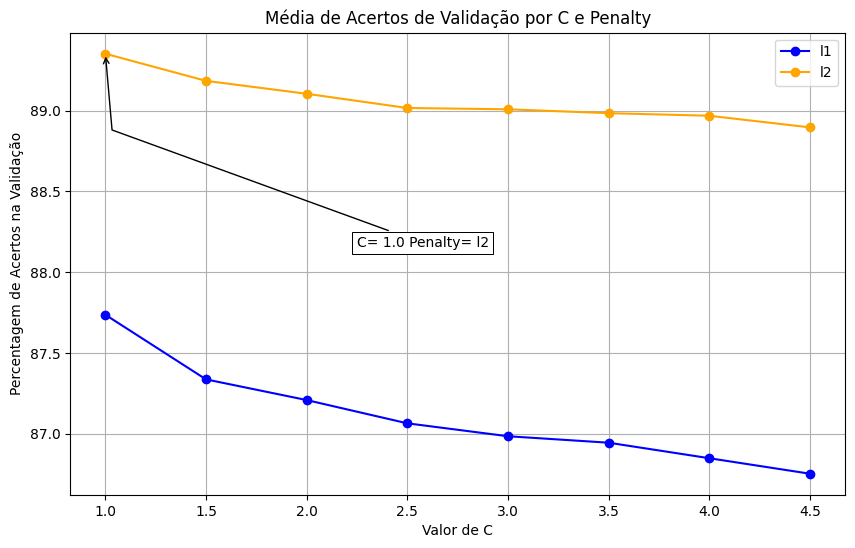

In [11]:
plt.figure(figsize=(10,6))
plt.plot(cs_b, resultados_c_p_b[0:8],  '-o', color='blue')
plt.plot(cs_b, resultados_c_p_b[8:16], '-o', color='orange')
annot_max(cs_b,resultados_c_p_b[8:16], combinacoes_c_p_b[8:16])
plt.title('Média de Acertos de Validação por C e Penalty')
plt.xlabel('Valor de C')
plt.ylabel('Percentagem de Acertos na Validação')
plt.legend(('l1', 'l2'))
plt.grid()    

### Melhores Valores

In [12]:
# Vetorização
tfidf_b = pickle.load(open(final_tfidf_bin, 'rb'))['tfidf']
X1t_b, X1v_b, X2_b = tfidf_b.transform(Docs1t_b), tfidf_b.transform(Docs1v_b), tfidf_b.transform(Docs2_b)

# Regressão Logística
lsvc_b = LinearSVC(dual=False, penalty='l2', C=1, max_iter=5000, tol=1e-2,random_state=42).fit(X1t_b, y1t_b)


svc_model_bin = 'Modelos/svc_model_bin.p'
pickle.dump({'lSVC' : lsvc_b}, open(svc_model_bin, 'wb'))

# Resultados
print('Tamanho Vocabulário:', len(tfidf_b.get_feature_names_out()))
print('Score Treino:', lsvc_b.score(X1t_b, y1t_b)*100)
print('Score Validação:', lsvc_b.score(X1v_b, y1v_b)*100)
print('Score Teste:', lsvc_b.score(X2_b, y2_b)*100)


Tamanho Vocabulário: 143323
Score Treino: 99.94800000000001
Score Validação: 91.03999999999999
Score Teste: 91.34400000000001


Número de Erros Teste:  1082
Matriz de Confusão Teste:



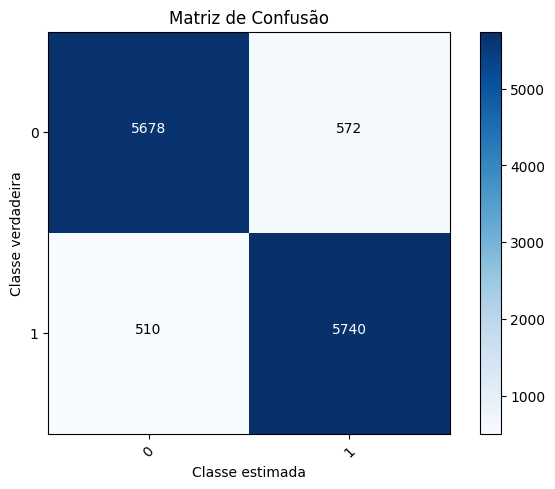

In [13]:
#Matriz Confusão Dados de Teste
print('Número de Erros Teste: ', np.sum(y2_b != lsvc_b.predict(X2_b)))
MC = confusion_matrix(y2_b, lsvc_b.predict(X2_b))
print('Matriz de Confusão Teste:')
plotMatriz(MC)
print()

Número de Erros Validação:  1120
Matriz de Confusão Validação:


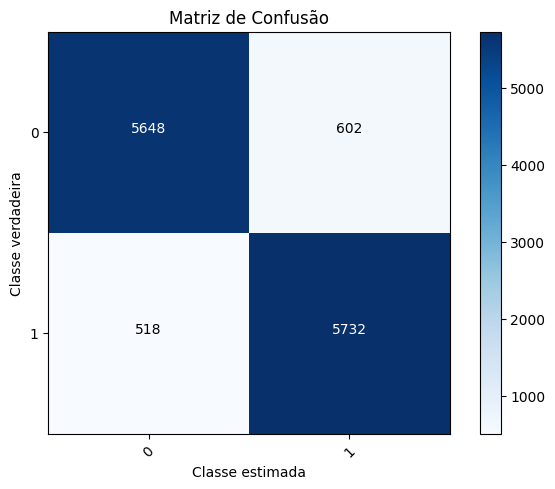

In [14]:
#Matriz de Confusão Dados de Validação
print('Número de Erros Validação: ', np.sum(y1v_b != lsvc_b.predict(X1v_b)))
MCV = confusion_matrix(y1v_b, lsvc_b.predict(X1v_b))
print('Matriz de Confusão Validação:')
plotMatriz(MCV)

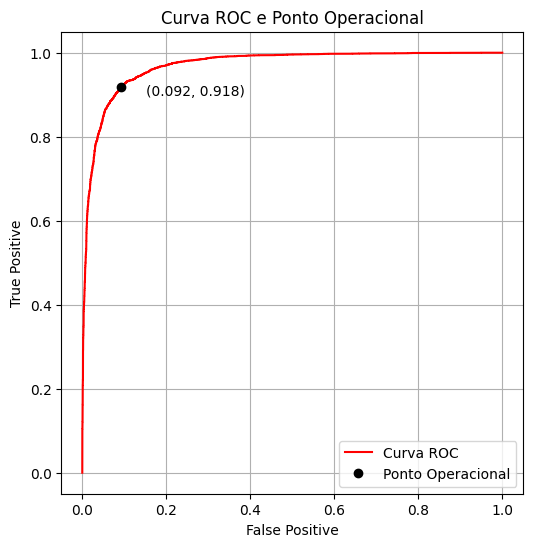

In [15]:
#Curva ROC
fpr, tpr, t = roc_curve(y2_b, lsvc_b.decision_function(X2_b))

# Pontos Classificação 
p1 = MC[0,1]/(MC[0,1] + MC[0,0])
p2 = MC[1,1]/(MC[1,1] + MC[1,0])

# Mostrar resultados...
plt.figure(figsize=(6,6))

# Plot da Curva ROC
plt.plot(fpr,tpr, color='red', label='Curva ROC')

# Plot dos Pontos
plt.plot(p1, p2, 'o', color='black', label='Ponto Operacional')
plt.title('Curva ROC e Ponto Operacional')
plt.ylabel('True Positive')
plt.xlabel('False Positive')
plt.legend()
plt.text(p1+0.06, p2-0.02, '(' + str(np.round(p1,3)) + ', ' + str(np.round(p2,3)) + ')' )
plt.axis('scaled')
plt.grid()
plt.show()

### Resultados

In [16]:
D = pickle.load(open(stemmed_data_path, 'rb'))

Docs_test_bin_svc, target_test_bin_svc = D['Docs'], D['y']

X_test_bin_svc  = text2vector(Docs_test_bin_svc, 'b', final_tfidf_bin)
ye_test_bin_svc = binClassify(X_test_bin_svc, 'SVC', False, svc_model_bin)


y_test_bin_svc = target_test_bin_svc.copy()
y_test_bin_svc[y_test_bin_svc < 5] = 0
y_test_bin_svc[y_test_bin_svc > 6] = 1

MC  = confusion_matrix(y_test_bin_svc, ye_test_bin_svc)

print('Matriz de Confusão Teste:')
print(MC)
print('\nNúmero de Erros: ', np.sum(y_test_bin_svc != ye_test_bin_svc))


Matriz de Confusão Teste:
[[23821  1179]
 [ 1036 23964]]

Número de Erros:  2215


## Caso Multi

In [17]:
yM = y.copy()

### Divisao em treino e teste

In [18]:
Docs1_m, Docs2_m, y1_m, y2_m     = tts(Docs, yM, test_size=1/4, stratify=yM,random_state=42) #total ---> treino + teste
Docs1t_m, Docs1v_m, y1t_m, y1v_m = tts(Docs1_m, y1_m, test_size=1/3, stratify=y1_m,random_state=42)  #treino ---> treino + validacao 

### Testar hyper parametros de "C" e "penalty"

In [19]:
final_tfidf_multi = 'tfidf/tfidf_multiclasse.p'

In [20]:
tfidf_m = pickle.load(open(final_tfidf_multi, 'rb'))['tfidf']
X1t_m, X1v_m = tfidf_m.transform(Docs1t_m), tfidf_m.transform(Docs1v_m)

cs_m =np.arange(0.5, 2, 0.1)
ps_m = ['l1', 'l2']

combinacoes_c_p_m     = [(p, c) for p in ps_m for c in cs_m]
resultados_c_p_m = []
for p, c in combinacoes_c_p_m:
    print(p, c)
    lsvc_m = LinearSVC(dual=False, penalty=p, C=c, max_iter=5000, tol=1e-2)
    resultados_c_p_m.append(np.mean(cross_val_score(lsvc_m, X1v_m, y1v_m, cv=3))*100)

l1 0.5
l1 0.6
l1 0.7
l1 0.7999999999999999
l1 0.8999999999999999
l1 0.9999999999999999
l1 1.0999999999999999
l1 1.1999999999999997
l1 1.2999999999999998
l1 1.4
l1 1.4999999999999998
l1 1.5999999999999996
l1 1.6999999999999997
l1 1.7999999999999998
l1 1.8999999999999997
l2 0.5
l2 0.6
l2 0.7
l2 0.7999999999999999
l2 0.8999999999999999
l2 0.9999999999999999
l2 1.0999999999999999
l2 1.1999999999999997
l2 1.2999999999999998
l2 1.4
l2 1.4999999999999998
l2 1.5999999999999996
l2 1.6999999999999997
l2 1.7999999999999998
l2 1.8999999999999997


In [21]:
svc_r_c_p_multi = 'Resultados/svc_r_c_p_multi.p'

In [22]:
dict_results_multi = {'parametros' : combinacoes_c_p_m, 
                    'scores'   : resultados_c_p_m
                   }

pickle.dump(dict_results_multi, open(svc_r_c_p_multi, 'wb'))

In [23]:
best_c_p_m = pickle.load(open(svc_r_c_p_multi, 'rb'))

combinacoes_c_p_m = best_c_p_m["parametros"]

resultados_c_p_m = best_c_p_m["scores"]

In [24]:
def annot_max(x,y,z,ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    zmax = z[np.argmax(y)]
    text= "C= " + str(zmax[1]) + " Penalty= " + zmax[0]
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.74,0.96), **kw)

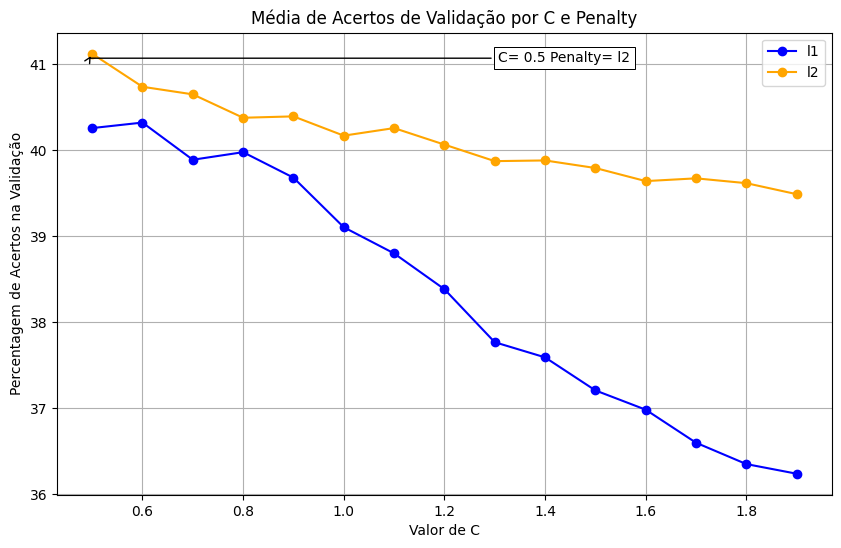

In [25]:
plt.figure(figsize=(10,6))
plt.plot(cs_m, resultados_c_p_m[0:15],  '-o', color='blue')
plt.plot(cs_m, resultados_c_p_m[15:30], '-o', color='orange')
annot_max(cs_m,resultados_c_p_m[15:30], combinacoes_c_p_m[15:30])
plt.title('Média de Acertos de Validação por C e Penalty')
plt.xlabel('Valor de C')
plt.ylabel('Percentagem de Acertos na Validação')
plt.legend(('l1', 'l2'))
plt.grid()    

### Melhores valores

In [26]:
# Vetorização
tfidf_m = pickle.load(open(final_tfidf_multi, 'rb'))['tfidf']
X1t_m, X1v_m, X2_m = tfidf_m.transform(Docs1t_m), tfidf_m.transform(Docs1v_m), tfidf_m.transform(Docs2_m)

# Regressão Logística
lsvc_m = LinearSVC(dual=False, penalty='l2', C=0.5, max_iter=5000, tol=1e-2,random_state=42) 
lsvc_m.fit(X1t_m, y1t_m)

svc_model_multi = 'Modelos/svc_model_multi.p'
pickle.dump({'lSVC' : lsvc_m}, open(svc_model_multi, 'wb'))

In [27]:
# Resultados
print('Tamanho Vocabulário:', len(tfidf_m.get_feature_names()))
print('Score Treino:', lsvc_m.score(X1t_m, y1t_m)*100)
print('Score Validação:', lsvc_m.score(X1v_m, y1v_m)*100)
print('Score Teste:', lsvc_m.score(X2_m, y2_m)*100)

Tamanho Vocabulário: 128551
Score Treino: 98.696
Score Validação: 42.792
Score Teste: 42.88


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Número de Erros Teste:  7140
Matriz de Confusão Teste:


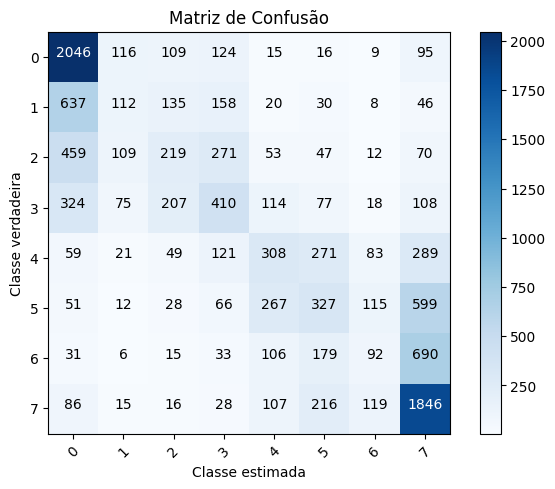

In [28]:
#Matriz Confusão Dados de Teste
print('Número de Erros Teste: ', np.sum(y2_m != lsvc_m.predict(X2_m)))
MC = confusion_matrix(y2_m, lsvc_m.predict(X2_m))
print('Matriz de Confusão Teste:')
plotMatriz(MC)

Número de Erros Validação:  7151
Matriz de Confusão Validação:


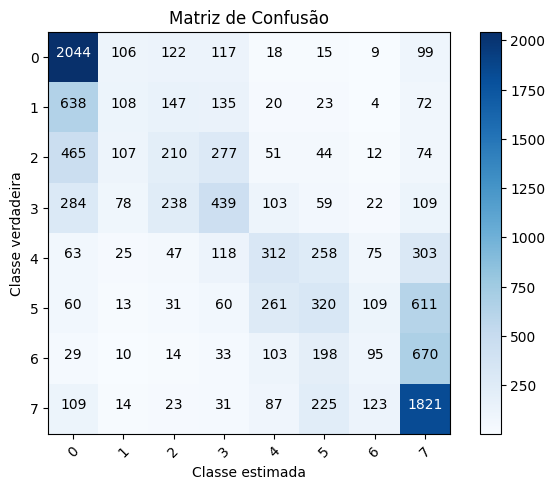

In [29]:
#Matriz de Confusão Dados de Validação
print('Número de Erros Validação: ', np.sum(y1v_m != lsvc_m.predict(X1v_m)))
MCV = confusion_matrix(y1v_m, lsvc_m.predict(X1v_m))
print('Matriz de Confusão Validação:')
plotMatriz(MCV)

### Resultados

In [30]:
D = pickle.load(open(stemmed_data_path, 'rb'))

Docs_test_multi_svc, y_test_multi_svc = D['Docs'], D['y']

X_test_multi_svc  = text2vector(Docs_test_multi_svc, 'm', final_tfidf_multi)
ye_test_multi_svc = multiClassify(X_test_multi_svc, 'SVC', False, svc_model_multi)


MC  = confusion_matrix(y_test_multi_svc, ye_test_multi_svc)

print('Matriz de Confusão Teste:')
print(MC)
print('\nNúmero de Erros: ', np.sum(y_test_multi_svc != ye_test_multi_svc))

Matriz de Confusão Teste:
[[9146  222  231  241   33   31   18  200]
 [1353 2434  282  293   40   53   12  119]
 [ 960  216 2870  549  104   91   24  147]
 [ 628  153  445 3493  217  136   40  219]
 [ 123   46   96  239 3008  530  159  602]
 [ 113   25   59  126  530 3529  227 1250]
 [  65   17   29   67  213  379 2379 1458]
 [ 198   29   39   60  196  441  244 8524]]

Número de Erros:  14617
